In [1]:
1+1

2

In [2]:
# increase cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
# !pip install --quiet tensorflow-hub
# !pip install --quiet seaborn

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

W0401 14:15:57.895999 140267849033472 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


In [10]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import random
import time
import pickle
import gc
import re

import numpy as np
import pandas as pd

from importlib import reload

import scipy.sparse

In [9]:
from helpers import load_data
from helpers import explore_data
from helpers import preprocess_data
from helpers import train_model

In [3]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/2" #@param ["https://tfhub.dev/google/universal-sentence-encoder/2", "https://tfhub.dev/google/universal-sentence-encoder-large/3"]

In [4]:
# Import the Universal Sentence Encoder's TF Hub module
embed = hub.Module(module_url)

Instructions for updating:
Colocations handled automatically by placer.


W0401 14:16:03.419278 140267849033472 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/control_flow_ops.py:3632: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


In [6]:
type(embed)

tensorflow_hub.module.Module

In [6]:
main_dir = '/tf/notebooks/'

In [7]:
data_path = main_dir + 'final-project/data/sample/hein-daily'

In [11]:
all_speech_ids, all_speeches = load_data.load_speech_data(data_path)


File speeches_097.txt has 249718612 characters
and 283399 speeches

Speeches list has 283399 speeches


In [12]:
reload(load_data)
start_time = time.time()
descr = load_data.load_descr_data(main_dir+'final-project/data/QA/full_descr.txt')
print("\nIt took {0:.1f} seconds to create the dictionary".format(time.time()-start_time))

2914465 lines have been read
37617 keys had duplicates and deleted
The dictionary has 2808050 keys

Random congressperson: 1120020786
char_count 147
word_count 27
NonWhite 0.0
speakerid 112121780.0
check 1
Chamber H
Age 42.0
Age_lt_med 1.0
State GA
speaker Mr. WOODALL
Congress 112
Party R
Full Name WOODALL, ROB
match exact
date 20110405
Ethnicity W
Female 0.0

It took 17.8 seconds to create the dictionary


In [13]:
gender = load_data.create_target_labels(all_speech_ids, descr)[0]
len(gender)

283399

In [14]:
train, train_ids, train_target, val, val_ids, val_target, test, test_ids, test_target = preprocess_data.split_train_val_test(all_speeches, all_speech_ids, gender, descr)

Training split: 1622 ones and 1622 zeroes
Training speech list size: 3244
Training target list size: 3244
Validation split: 540 ones and 540 zeroes
Validation speech list size: 1080
Validation target list size: 1080
Test split: 542 ones and 542 zeroes
Test speech list size: 1084
Test target list size: 1084


In [146]:
chunk_len=30

In [147]:
reload(preprocess_data)
train_chunk, train_ids_chunk, train_target_chunk = preprocess_data.split_speech_to_chunks(train, train_ids, train_target, max_len=chunk_len)

Original data has 3244 speeches
It was split into 37989 chunks
Checks on ids and target 37989 37989
Original target mean 0.5
New target mean 0.5066203374661086


In [148]:
val_chunk, val_ids_chunk, val_target_chunk = preprocess_data.split_speech_to_chunks(val, val_ids, val_target, max_len=chunk_len)

Original data has 1080 speeches
It was split into 12903 chunks
Checks on ids and target 12903 12903
Original target mean 0.5
New target mean 0.4755483220956367


In [149]:
train_chunk[:2]

['Mr. Speaker. I want to compliment the gentleman from California for his comments. I think one of the things that he and the gentleman from Wisconsin were pointing out is',
 'that they had some perfecting punendments to the Commission that would have made it better. I think some of the things that people worried about were the calendar days rather']

In [150]:
#del descr

In [151]:
# Reduce logging output.
tf.logging.set_verbosity(tf.logging.ERROR)

start_time = time.time()
with tf.Session() as session:
    session.run([tf.global_variables_initializer(), tf.tables_initializer()])
    train_embeddings = session.run(embed(train_chunk))
print("\nIt took {0:.1f} seconds to create embeddings".format(time.time()-start_time))


It took 43.7 seconds to create embeddings


In [152]:
train_embeddings.shape

(37989, 512)

In [153]:
start_time = time.time()
with tf.Session() as session:
    session.run([tf.global_variables_initializer(), tf.tables_initializer()])
    val_embeddings = session.run(embed(val_chunk))
print("\nIt took {0:.1f} seconds to create embeddings".format(time.time()-start_time))


It took 23.0 seconds to create embeddings


In [154]:
val_embeddings.shape

(12903, 512)

In [155]:
logs_base_dir = main_dir+"final-project/Classification/logs"

In [191]:
mlp_model_params = {
    'model': 'mlp',
    'learning_rate': 0.001,
    'epochs': 1000,
    'batch_size': 128,
    'layers': 2,
    'units': 64,
    'dropout_rate': 0.2
}

In [192]:
reload(train_model)
history, train_pred_probs, val_pred_probs = train_model.train_model(((train_embeddings, train_target_chunk), (val_embeddings, val_target_chunk)), logs_base_dir, **mlp_model_params)

Train on 37989 samples, validate on 12903 samples
Epoch 1/1000
 - 3s - loss: 0.6712 - acc: 0.5853 - val_loss: 0.6597 - val_acc: 0.6055
Epoch 2/1000
 - 1s - loss: 0.6600 - acc: 0.5992 - val_loss: 0.6577 - val_acc: 0.6074
Epoch 3/1000
 - 1s - loss: 0.6543 - acc: 0.6066 - val_loss: 0.6538 - val_acc: 0.6106
Epoch 4/1000
 - 1s - loss: 0.6495 - acc: 0.6157 - val_loss: 0.6512 - val_acc: 0.6130
Epoch 5/1000
 - 1s - loss: 0.6445 - acc: 0.6207 - val_loss: 0.6513 - val_acc: 0.6099
Epoch 6/1000
 - 1s - loss: 0.6413 - acc: 0.6261 - val_loss: 0.6520 - val_acc: 0.6113
Validation accuracy: 0.6113306879997253, loss: 0.6520250675189146


In [193]:
val_preds = val_pred_probs > 0.5
np.sum(val_preds.flatten()==val_target_chunk)

7888

Confusion matrix, without normalization
[[4043 2724]
 [2291 3845]]
              precision    recall  f1-score   support

        Male       0.64      0.60      0.62      6767
      Female       0.59      0.63      0.61      6136

   micro avg       0.61      0.61      0.61     12903
   macro avg       0.61      0.61      0.61     12903
weighted avg       0.61      0.61      0.61     12903



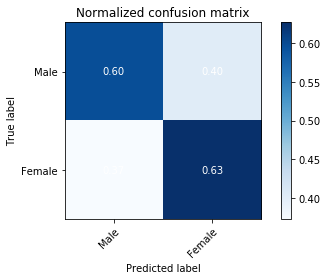

In [194]:
reload(explore_data)
# specify class names in 0 - 1 order
classes = ['Male', 'Female']
explore_data.plot_confusion_matrix(val_target_chunk, val_preds, classes, normalize=True)

In [195]:
pred_df = pd.DataFrame({'ids': val_ids_chunk, 'target': val_target_chunk, 'probs': val_pred_probs.flatten(), 'preds': val_preds.flatten()})

In [196]:
f = {'probs': [min, max, 'mean']}
pred_aggr_df = pred_df.groupby('ids').agg(f).reset_index()
pred_aggr_df.columns = ['ids', 'probs_min', 'probs_max', 'probs_mean']
pred_aggr_df = pred_aggr_df.merge(pred_df[['target', 'ids']].groupby('ids').mean().reset_index(), on='ids')
pred_aggr_df = pred_aggr_df.merge(pred_df[['preds', 'ids']].groupby('ids').mean().reset_index(), on='ids')
pred_aggr_df['preds_probs_mean'] = pred_aggr_df['probs_mean'].apply(lambda x: 1 if x > 0.5 else 0)
pred_aggr_df['preds_mean'] = pred_aggr_df['preds'].apply(lambda x: 1 if x > 0.5 else 0)
pred_aggr_df.head()

,ids,probs_min,probs_max,probs_mean,target,preds,preds_probs_mean,preds_mean
0,970000644,0.302960,0.645586,0.458256,0,0.250000,0,0
1,970000718,0.242646,0.675970,0.534742,0,0.666667,1,1
2,970000863,0.319639,0.650005,0.522330,1,0.571429,1,1
3,970000895,0.154204,0.212298,0.183251,0,0.000000,0,0
4,970001533,0.361256,0.493908,0.443886,0,0.000000,0,0


In [197]:
np.mean(val_target_chunk == val_preds.flatten())

0.61133069828722

In [198]:
np.mean(pred_aggr_df.target == pred_aggr_df.preds_probs_mean)

0.6648148148148149

In [199]:
np.mean(pred_aggr_df.target == pred_aggr_df.preds_mean)

0.6638888888888889

Confusion matrix, without normalization
[[367 173]
 [189 351]]
              precision    recall  f1-score   support

        Male       0.66      0.68      0.67       540
      Female       0.67      0.65      0.66       540

   micro avg       0.66      0.66      0.66      1080
   macro avg       0.66      0.66      0.66      1080
weighted avg       0.66      0.66      0.66      1080



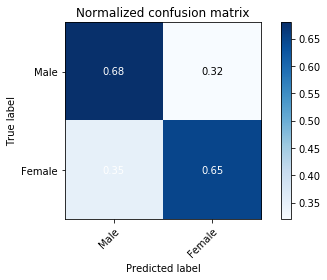

In [200]:
explore_data.plot_confusion_matrix(pred_aggr_df.target, pred_aggr_df.preds_probs_mean, classes, normalize=True)

Confusion matrix, without normalization
[[387 153]
 [210 330]]
              precision    recall  f1-score   support

        Male       0.65      0.72      0.68       540
      Female       0.68      0.61      0.65       540

   micro avg       0.66      0.66      0.66      1080
   macro avg       0.67      0.66      0.66      1080
weighted avg       0.67      0.66      0.66      1080



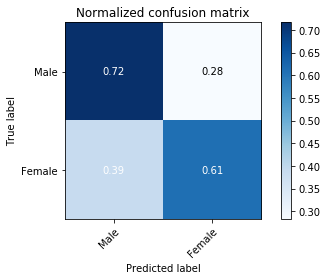

In [201]:
explore_data.plot_confusion_matrix(pred_aggr_df.target, pred_aggr_df.preds_mean, classes, normalize=True)

Confusion matrix, without normalization
[[522  34]
 [ 75 449]]
              precision    recall  f1-score   support

        Male       0.87      0.94      0.91       556
      Female       0.93      0.86      0.89       524

   micro avg       0.90      0.90      0.90      1080
   macro avg       0.90      0.90      0.90      1080
weighted avg       0.90      0.90      0.90      1080



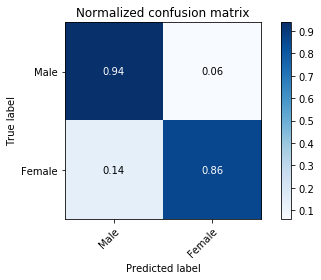

In [202]:
explore_data.plot_confusion_matrix(pred_aggr_df.preds_probs_mean, pred_aggr_df.preds_mean, classes, normalize=True)